In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [2]:
def model_performance(y_train, y_pred_train, y_test, y_pred_test):

    ME_train = np.mean(np.exp(y_train)-np.exp(y_pred_train))
    ME_test  = np.mean(np.exp(y_test)-np.exp(y_pred_test))

    MAE_train = mean_absolute_error(np.exp(y_train),np.exp(y_pred_train))
    MAE_test  = mean_absolute_error(np.exp(y_test),np.exp(y_pred_test))

    MSE_train = mean_squared_error(np.exp(y_train),np.exp(y_pred_train))
    MSE_test  = mean_squared_error(np.exp(y_test),np.exp(y_pred_test))

    RMSE_train = np.sqrt(MSE_train)
    RMSE_test  = np.sqrt(MSE_test)

    MAPE_train = np.mean((np.abs(np.exp(y_train)-np.exp(y_pred_train)) / np.exp(y_train))* 100.)
    MAPE_test  = np.mean((np.abs(np.exp(y_test)-np.exp(y_pred_test)) / np.exp(y_test))* 100.)

    R2_train = r2_score(np.exp(y_train),np.exp(y_pred_train))
    R2_test  = r2_score(np.exp(y_test),np.exp(y_pred_test))

    performance = pd.DataFrame({'Error_metric': ['Mean error','Mean absolute error','Mean squared error',
                                             'Root mean squared error','Mean absolute percentual error',
                                             'R2'],
                            'Train': [ME_train, MAE_train, MSE_train, RMSE_train, MAPE_train, R2_train],
                            'Test' : [ME_test, MAE_test , MSE_test, RMSE_test, MAPE_test, R2_test]})

    pd.options.display.float_format = '{:.2f}'.format

    df_train = pd.DataFrame({'Real': np.exp(y_train), 'Predicted': np.exp(y_pred_train)})
    df_test  = pd.DataFrame({'Real': np.exp(y_test),  'Predicted': np.exp(y_pred_test)})

    return performance, df_train, df_test

In [3]:
#Loading dataset
df = pd.read_csv("Data\Customer_churn.csv")

In [4]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


In [5]:
#Looking for nans
df.isnull().values.any()

False

In [6]:
# Columns to lower case
df.columns= df.columns.str.lower()
df.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'phoneservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   onlinesecurity    7043 non-null   object 
 7   onlinebackup      7043 non-null   object 
 8   deviceprotection  7043 non-null   object 
 9   techsupport       7043 non-null   object 
 10  streamingtv       7043 non-null   object 
 11  streamingmovies   7043 non-null   object 
 12  contract          7043 non-null   object 
 13  monthlycharges    7043 non-null   float64
 14  totalcharges      7043 non-null   object 
 15  churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

In [8]:
#Converting df. to numeric
df["totalcharges"] = pd.to_numeric(df["totalcharges"], errors='coerce')   

In [9]:
#There are 11 nans in totalcharges now
df["totalcharges"].isnull().sum()

11

In [10]:
#Removing rows with nans in totalcharges
df = df[df['totalcharges'].notna()]

# Logistic regression with cross-validation

In [11]:
#X/y split
X = df.drop("churn", axis=1)
y = df["churn"]

In [12]:
#Splitting numerical and categorical columns
X_num = X[["tenure", "monthlycharges", "totalcharges"]]
X_cat = X.drop(["tenure", "monthlycharges", "totalcharges"], axis=1)

In [13]:
X_num.head()

,tenure,monthlycharges,totalcharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


In [14]:
#Getting dummies for X_cat
X_cat = pd.get_dummies(X_cat)

In [15]:
#Concatenating X_num and X_cat again
X_num.reset_index(drop=True, inplace=True)
X_cat.reset_index(drop=True, inplace=True)

X = pd.concat([X_num, X_cat], axis = 1)

In [16]:
X.columns

Index(['tenure', 'monthlycharges', 'totalcharges', 'seniorcitizen',
       'gender_Female', 'gender_Male', 'partner_No', 'partner_Yes',
       'dependents_No', 'dependents_Yes', 'phoneservice_No',
       'phoneservice_Yes', 'onlinesecurity_No',
       'onlinesecurity_No internet service', 'onlinesecurity_Yes',
       'onlinebackup_No', 'onlinebackup_No internet service',
       'onlinebackup_Yes', 'deviceprotection_No',
       'deviceprotection_No internet service', 'deviceprotection_Yes',
       'techsupport_No', 'techsupport_No internet service', 'techsupport_Yes',
       'streamingtv_No', 'streamingtv_No internet service', 'streamingtv_Yes',
       'streamingmovies_No', 'streamingmovies_No internet service',
       'streamingmovies_Yes', 'contract_Month-to-month', 'contract_One year',
       'contract_Two year'],
      dtype='object')

In [17]:
# Train/test split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

In [18]:
# Splitting X_train to num and cat to fit standard scaler on X_train and transform X_train and X_test
X_train_num = X_train[["tenure", "monthlycharges", "totalcharges"]]
X_test_num = X_test[["tenure", "monthlycharges", "totalcharges"]]

X_train_cat = X_train.drop(["tenure", "monthlycharges", "totalcharges"], axis=1)
X_test_cat = X_test.drop(["tenure", "monthlycharges", "totalcharges"], axis=1)

In [19]:
#Scaling X_train_num and X_test_num
scaler=StandardScaler()

#Fitting on X_train_num
scaler.fit(X_train_num)

#Transforming X_train_num and X_test_num
X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [20]:
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=["tenure", "monthlycharges", "totalcharges"])
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=["tenure", "monthlycharges", "totalcharges"])

In [21]:
#Concatenating train and test sets again
X_train_num_scaled.reset_index(drop=True, inplace=True)
X_test_num_scaled.reset_index(drop=True, inplace=True)
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)

X_train = pd.concat([X_train_num_scaled, X_train_cat], axis = 1)
X_test = pd.concat([X_test_num_scaled, X_test_cat], axis = 1)

In [22]:
# Converting yes/no in target column to 0 and 1 
y_train = y_train.replace(['No'], 1)
y_train = y_train.replace(['Yes'], 0)

y_test = y_test.replace(['No'], 1)
y_test = y_test.replace(['Yes'], 0)

In [23]:
y_train.value_counts()

1    3679
0    1243
Name: churn, dtype: int64

In [24]:
# Fitting logistic regression on X_train and y_train
model_lr = LogisticRegression(random_state=123)
model_lr.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [25]:
#Results for train and test sets
y_pred_train = model_lr.predict(X_train)
y_pred_test = model_lr.predict(X_test)

In [27]:
performance_log = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

In [29]:
#Accuracy = (true positive + true negative)/(true positive + true negative + false positive + false negative)
# = overall accuracy

#Precision = true positive/(true positive + false positive)
# = ratio of true positive to all predicted positive

#Recall = true positive/(true positive + false negative)
# = what percentage of positives was predicted correctly 
# = predicted positives / all positives

display(performance_log)

,Error_metric,Train,Test
0,Accuracy,0.802722,0.798578
1,Precision,0.842958,0.819168
2,Recall,0.904594,0.915768


In [30]:
#Cross-validation for X_train
model_lr = LogisticRegression()
scores=cross_val_score(model_lr, X_train, y_train, cv=10)
print(scores)

[0.79513185 0.78701826 0.78455285 0.80487805 0.78252033 0.78252033
 0.82520325 0.79471545 0.82520325 0.80691057]


In [31]:
print("Confusion matrix for the train set")
print(confusion_matrix(y_train,y_pred_train))
plot_confusion_matrix(model_lr,X_train,y_train, values_format = 'd')
plt.show()

Confusion matrix for the train set
[[ 623  620]
 [ 351 3328]]


C:\Users\atycn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [32]:
print("Confusion matrix for the test set")
print(confusion_matrix(y_test, y_pred_test_log))
plot_confusion_matrix(log_model,X_test,y_test, values_format = 'd')
plt.show()

Confusion matrix for the test set


NameError: name 'y_pred_test_log' is not defined

# KNN with cross validation and downsampling

In [33]:
# For KNN scaling needed but here data was already scaled with standard scaler for logistic regression, 
# so I'm not doing it again; data already downsampled

In [34]:
model_knn = KNeighborsRegressor(n_neighbors=3)

In [35]:
#Fitting on X_train and y_train
model_knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [36]:
# Predictions
y_pred_train_knn = model_knn.predict(X_train)
y_pred_test_knn  = model_knn.predict(X_test)

In [37]:
performance_knn, _, _ = model_performance(y_train, y_pred_train_knn, y_test, y_pred_test_knn)
performance_knn

,Error_metric,Train,Test
0,Mean error,0.09,0.05
1,Mean absolute error,0.32,0.51
2,Mean squared error,0.28,0.59
3,Root mean squared error,0.53,0.77
4,Mean absolute percentual error,19.43,33.70
5,R2,0.49,0.05


In [38]:
full = pd.DataFrame()

models = {'k': [] }

for k in range(2,21):

    neighbours = KNeighborsRegressor(n_neighbors=k)
    neighbours.fit(X_train, y_train)

    models['k'] = [k, neighbours]

    y_pred_train_knn = neighbours.predict(X_train)
    y_pred_test_knn  = neighbours.predict(X_test)

    performance_knn, _, _ = model_performance(y_train, y_pred_train_knn, y_test, y_pred_test_knn)
    temp = pd.DataFrame({'k': [k]*6, 'Error_metric': performance_knn['Error_metric'], 
                         'Train': performance_knn['Train'], 'Test': performance_knn['Test']})
    full = pd.concat([full,temp], axis=0)

print(full)

     k                    Error_metric  Train  Test
0    2                      Mean error   0.07  0.02
1    2             Mean absolute error   0.24  0.51
2    2              Mean squared error   0.22  0.67
3    2         Root mean squared error   0.47  0.82
4    2  Mean absolute percentual error  14.30 34.33
..  ..                             ...    ...   ...
1   20             Mean absolute error   0.50  0.53
2   20              Mean squared error   0.42  0.46
3   20         Root mean squared error   0.65  0.68
4   20  Mean absolute percentual error  29.61 33.39
5   20                              R2   0.25  0.26

[114 rows x 4 columns]


In [39]:
full[full['Error_metric'] == 'R2']

,k,Error_metric,Train,Test
5,2,R2,0.60,-0.09
5,3,R2,0.49,0.05
5,4,R2,0.43,0.12
5,5,R2,0.39,0.16
5,6,R2,0.37,0.19
5,7,R2,0.35,0.21
5,8,R2,0.33,0.21
5,9,R2,0.32,0.23
5,10,R2,0.31,0.23
5,11,R2,0.30,0.23


# Decision trees with cross-validation and downsampling

No scaling needed for decission trees. Dummies are only needed because sklearn doesn't take strings 

In [40]:
#Loading dataset for decission trees model (same dataset as df2)
df2 = pd.read_csv("Data\Customer_churn.csv")

In [41]:
df2.columns= df.columns.str.lower()
df2["totalcharges"] = pd.to_numeric(df2["totalcharges"], errors='coerce')   
df2 = df2[df2['totalcharges'].notna()]

In [42]:
df2["churn"] = df2["churn"].apply(lambda x: 1 if x == "No" else 0)

In [43]:
df2["churn"].value_counts()

1    5163
0    1869
Name: churn, dtype: int64

In [44]:
#Checking imbalance in target column for balancing the data
df2["churn"].value_counts()

1    5163
0    1869
Name: churn, dtype: int64

In [45]:
#Checking percentage of the majority class in target column
5165/len(df2["churn"])

0.7344994311717861

In [46]:
#Splitting df into records with No and Yes in the target column
category_NO = df2[df2['churn'] == 0]
category_YES = df2[df2['churn'] == 1]
print(category_NO.shape)
print(category_YES.shape)

(1869, 16)
(5163, 16)


In [47]:
#Downsampling category_YES to the size of category_YES
category_YES_down = category_YES.sample(len(category_NO))
category_YES_down.shape

(1869, 16)

In [48]:
#Concatenating category_NO_down and category_YES into one df
df2 = pd.concat([category_YES_down, category_NO], axis=0)

In [49]:
#Upper part of df == NO, bottom part == YES >>>> shuffling df for the X/y split
df2 = df2.sample(frac=1)

In [50]:
#Now df is balanced and shuffled
df2['churn'].value_counts()

0    1869
1    1869
Name: churn, dtype: int64

In [51]:
#X/y split
X2 = df2.drop("churn", axis=1)
y2 = df2["churn"]

In [52]:
X2_train, X2_test, y2_train, y2_test=train_test_split(X2, y2, test_size=.30,random_state=123)

In [53]:
#Splitting numerical and categorical columns
X2_train_num = X2_train[["tenure", "monthlycharges", "totalcharges"]]
X2_train_cat = X2_train.drop(["tenure", "monthlycharges", "totalcharges"], axis=1)

X2_test_num = X2_test[["tenure", "monthlycharges", "totalcharges"]]
X2_test_cat = X2_test.drop(["tenure", "monthlycharges", "totalcharges"], axis=1)

In [54]:
#Getting dummies for X_cat
X2_train_cat = pd.get_dummies(X2_train_cat, drop_first = True)
X2_test_cat = pd.get_dummies(X2_test_cat, drop_first = True)

In [55]:
#Concatenating X_num and X_cat again
X2_train_num.reset_index(drop=True, inplace=True)
X2_train_cat.reset_index(drop=True, inplace=True)

X2_test_num.reset_index(drop=True, inplace=True)
X2_test_cat.reset_index(drop=True, inplace=True)

X2_train = pd.concat([X2_train_num, X2_train_cat], axis = 1)
X2_test = pd.concat([X2_test_num, X2_test_cat], axis = 1)

In [56]:
X2_train.columns

Index(['tenure', 'monthlycharges', 'totalcharges', 'seniorcitizen',
       'gender_Male', 'partner_Yes', 'dependents_Yes', 'phoneservice_Yes',
       'onlinesecurity_No internet service', 'onlinesecurity_Yes',
       'onlinebackup_No internet service', 'onlinebackup_Yes',
       'deviceprotection_No internet service', 'deviceprotection_Yes',
       'techsupport_No internet service', 'techsupport_Yes',
       'streamingtv_No internet service', 'streamingtv_Yes',
       'streamingmovies_No internet service', 'streamingmovies_Yes',
       'contract_One year', 'contract_Two year'],
      dtype='object')

In [57]:
model_dt = DecisionTreeClassifier(max_depth=5)

model_dt.fit(X2_train, y2_train)

y2_pred_train_dt = model_dt.predict(X2_train)
y2_pred_test_dt =model_dt.predict(X2_test)

In [58]:
y2_pred_train_dt

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [59]:
scores_dt=cross_val_score(model_dt, X2_train, y2_train, cv=5)
print(scores_dt)

[0.72328244 0.77055449 0.73231358 0.73422562 0.75334608]


,Error_metric,Train,Test
0,Accuracy,0.77,0.74
1,Precision,0.78,0.74
2,Recall,0.75,0.73


Confusion matrix for the train set
[[1007  327]
 [ 281 1001]]


C:\Users\atycn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


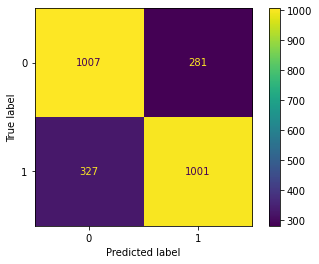



Confusion matrix for the test set
[[440 148]
 [141 393]]


C:\Users\atycn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


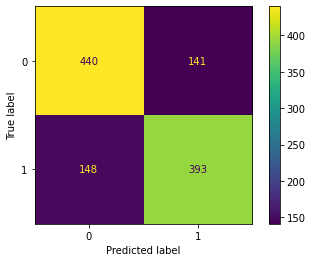

In [60]:
performance_df_dt_with_downsampling = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y2_train, y2_pred_train_dt),
                                         precision_score(y2_train, y2_pred_train_dt),
                                         recall_score(y2_train, y2_pred_train_dt)],
                               'Test': [accuracy_score(y2_test, y2_pred_test_dt),
                                        precision_score(y2_test, y2_pred_test_dt),
                                        recall_score(y2_test, y2_pred_test_dt)]})

display(performance_df_dt_with_downsampling)

print("Confusion matrix for the train set")
print(confusion_matrix(y2_train,y2_pred_train_dt).T)
plot_confusion_matrix(model_dt,X2_train,y2_train, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y2_test,y2_pred_test_dt).T)
plot_confusion_matrix(model_dt,X2_test,y2_test, values_format = 'd')
plt.show()

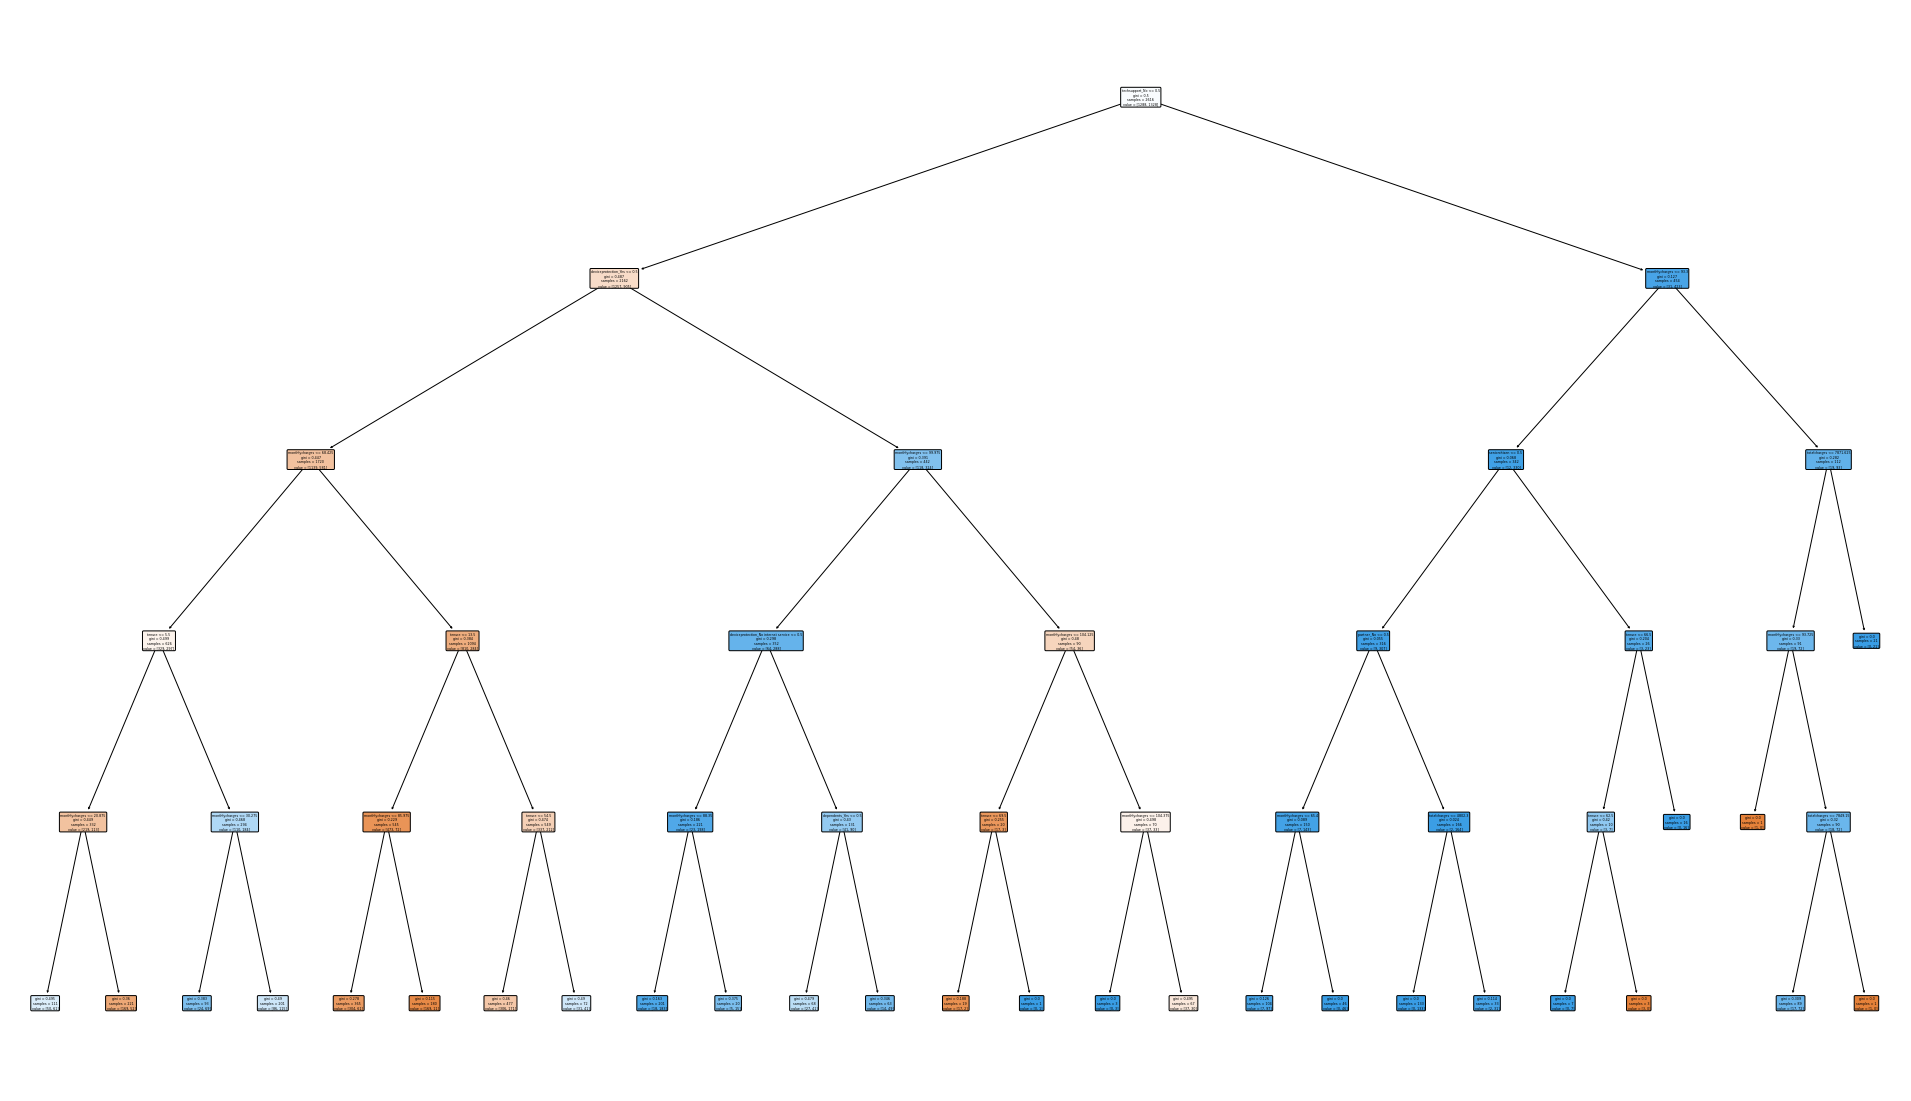

In [61]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (34,20))

plot_tree(model_dt,filled = True, rounded=True,feature_names=X.columns)
plt.show() 

# Decision trees with cross-validation and upsampling with SMOTE

In [112]:
#Loading dataset for decission trees model (same dataset as df2)
df_dt_up = pd.read_csv("Data\Customer_churn.csv")

In [113]:
df_dt_up.columns= df.columns.str.lower()
df_dt_up["totalcharges"] = pd.to_numeric(df_dt_up["totalcharges"], errors='coerce')   
df_dt_up = df_dt_up[df_dt_up['totalcharges'].notna()]

In [114]:
df_dt_up["churn"] = df_dt_up["churn"].apply(lambda x: 1 if x == "No" else 0)

In [115]:
df_dt_up["churn"].value_counts()

1    5163
0    1869
Name: churn, dtype: int64

In [116]:
#Checking imbalance in target column for balancing the data
df_dt_up["churn"].value_counts()

1    5163
0    1869
Name: churn, dtype: int64

In [117]:
#Upsampling with SMOTE after X/y split >>> SMOTE has to know which column is the target feature
#And after getting dummies >>> SMOTE doesn't work for strings
#X/y split
X_dt_up = df_dt_up.drop("churn", axis=1)
y_dt_up = df_dt_up["churn"]

In [118]:
#Getting dummies for categorical columns
X_dt_up = pd.get_dummies(data=X_dt_up, columns= ["gender", "partner", "dependents", "phoneservice",
                                                 "onlinesecurity", "onlinebackup", "deviceprotection",
                                                "techsupport", "streamingtv", "streamingmovies", "contract",
                                                ], drop_first=True)

# pd.get_dummies(X2_train_cat, drop_first = True)

In [119]:
#Upsampling with SMOTE
smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X_dt_up, y_dt_up)

In [70]:
y_sm.value_counts()

1    5163
0    5163
Name: churn, dtype: int64

In [71]:
#Train/test split (from upsampled X_sm and y_sm)
X_dt_up_train, X_dt_up_test, y_dt_up_train, y_dt_up_test=train_test_split(X_sm, y_sm, test_size=.30,random_state=123)

In [72]:
X_dt_up_test.shape

(3098, 22)

In [73]:
#Chossing the model: decision tree classifier
model_dt_up = DecisionTreeClassifier(max_depth=5)

In [74]:
#Fitting and running the model
model_dt_up.fit(X_dt_up_train, y_dt_up_train)

y_pred_train_dt_up = model_dt_up.predict(X_dt_up_train)
y_pred_test_dt_up = model_dt_up.predict(X_dt_up_test)

In [75]:
X_dt_up_test.shape

(3098, 22)

In [76]:
#Cross-validation on the train set
scores_dt_up=cross_val_score(model_dt_up, X_dt_up_train, y_dt_up_train, cv=5)
print(scores_dt)

[0.72328244 0.77055449 0.73231358 0.73422562 0.75334608]


,Error_metric,Train,Test
0,Accuracy,0.77,0.74
1,Precision,0.78,0.74
2,Recall,0.75,0.73


Confusion matrix for the train set
[[3032  794]
 [ 551 2851]]


C:\Users\atycn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


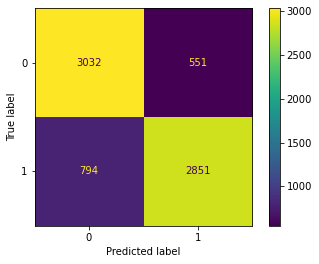



Confusion matrix for the test set
[[1336  364]
 [ 244 1154]]


C:\Users\atycn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


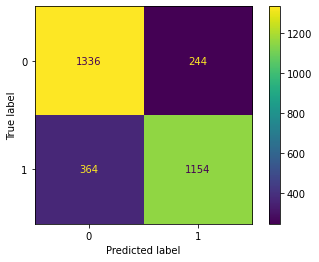

In [77]:
performance_dt_up = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_dt_up_train, y_pred_train_dt_up),
                                         precision_score(y_dt_up_train, y_pred_train_dt_up),
                                         recall_score(y_dt_up_train, y_pred_train_dt_up)],
                               'Test': [accuracy_score(y_dt_up_test, y_pred_test_dt_up),
                                        precision_score(y_dt_up_test, y_pred_test_dt_up),
                                        recall_score(y_dt_up_test, y_pred_test_dt_up)]})

display(performance_df_dt_with_downsampling)

print("Confusion matrix for the train set")
print(confusion_matrix(y_dt_up_train,y_pred_train_dt_up).T)
plot_confusion_matrix(model_dt_up,X_dt_up_train,y_dt_up_train, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_dt_up_test,y_pred_test_dt_up).T)
plot_confusion_matrix(model_dt_up,X_dt_up_test,y_dt_up_test, values_format = 'd')
plt.show()

In [78]:
model_pipeline = [model_lr, model_knn, model_dt, model_dt_up]
model_names = ['Linear Regression', 'KNN', 'DT downsampling.', 'DT upsampling.']
scores = {}
i=0
for model in model_pipeline:
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=5))
    scores[model_names[i]] = mean_score
    i = i+1
print(scores)

{'Linear Regression': 0.800896991457224, 'KNN': 0.042765636858068556, 'DT downsampling.': 0.7996787173455491, 'DT upsampling.': 0.7992724196277495}


# Random forest with SMOTE upsampling 

In [142]:
#Loading dataset for decission trees model (same dataset as df2)
df_rf = pd.read_csv("Data\Customer_churn.csv")

In [143]:
df_rf.columns= df.columns.str.lower()
df_rf["totalcharges"] = pd.to_numeric(df_rf["totalcharges"], errors='coerce')   
df_rf = df_dt_up[df_rf['totalcharges'].notna()]

C:\Users\atycn\AppData\Local\Temp/ipykernel_18516/1087954079.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rf = df_dt_up[df_rf['totalcharges'].notna()]


In [145]:
df_rf["churn"].value_counts()

1    5163
0    1869
Name: churn, dtype: int64

In [148]:
#Upsampling with SMOTE after X/y split >>> SMOTE has to know which column is the target feature
#And after getting dummies >>> SMOTE doesn't work for strings
#X/y split

X_df_rf = df_rf.drop("churn", axis=1)
y_df_rf = df_rf["churn"]

In [149]:
#Getting dummies for categorical columns
X_df_rf = pd.get_dummies(data=X_df_rf, columns= ["gender", "partner", "dependents", "phoneservice",
                                                 "onlinesecurity", "onlinebackup", "deviceprotection",
                                                "techsupport", "streamingtv", "streamingmovies", "contract",
                                                ], drop_first=True)

# pd.get_dummies(X2_train_cat, drop_first = True)

In [150]:
#Upsampling with SMOTE
smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X_df_rf, y_df_rf)

In [151]:
y_sm.value_counts()

1    5163
0    5163
Name: churn, dtype: int64

In [152]:
#Train/test split (from upsampled X_sm and y_sm)
X_df_rf_train, X_df_rf_test, y_df_rf_train, y_df_rf_test=train_test_split(X_sm, y_sm, test_size=.30,random_state=123)

In [153]:
X_df_rf_test.shape

(3098, 22)

In [155]:
#Random forest
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_df_rf_train, y_df_rf_train)
print(clf.score(X_df_rf_test, y_df_rf_test))

0.7921239509360878


In [156]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
cross_val_scores = cross_val_score(clf, X_df_rf_train, y_df_rf_train, cv=10)
cross_val_scores

array([0.78838174, 0.80082988, 0.78976487, 0.77593361, 0.77316736,
       0.80082988, 0.77316736, 0.81051176, 0.78116343, 0.80609418])

In [157]:
np.mean(cross_val_scores)

0.7899844063095061

In [158]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100,500],
    'min_samples_split': [2, 4],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt']
#    'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=100)

In [159]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [160]:
grid_search.fit(X_df_rf_train,y_df_rf_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True)

In [169]:
grid_search.best_score_

0.8346723331753985

In [161]:
grid_search.best_params_ 

{'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [166]:
clf = RandomForestClassifier(random_state=0, max_features='sqrt', 
                             min_samples_leaf=2, min_samples_split=2, n_estimators=100)
cross_val_scores = cross_val_score(clf, X_df_rf_train, y_df_rf_train, cv=10)
print(np.mean(cross_val_scores))

0.8341189564870902


In [167]:
#Feature importance

In [165]:
feature_names = X_df_rf_train.columns
feature_names = list(feature_names)